# Regression - Dummy- GLOB/SEAA/CARB

## Notebook Setup

### Import Libraries

In [31]:
# Import Standard Libraries
import os
import datetime
import pickle
import pandas as pd
import numpy as np

# Import Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import shap

# Import custom functions
import env_functions as ef
import s3_functions as sf
import common_functions as cf

In [32]:
# Import Modeling Libraries
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [33]:
# Determine the environment and get appropriate vars
deepnote, env_vars = ef.load_env_vars()

# Iterate through the vars and set them as global vars
for var_name, var in env_vars.items():
    globals()[var_name] = var

# If not in the DeepNote environment, create a dict for aws creds
#   that were located in the environment file.  This will be passed
#   to all aws s3 functions.
if not deepnote:
    aws_env_vars = {
        'access_key_id': aws_access_key_id,
        'secret_access_key': aws_secret_access_key,
        'bucket_name': s3_bucket_name
    }

Loading dotenv file


In [34]:
# Pandas Configs
pd.set_option('mode.chained_assignment', None)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Ignore Warnings
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# MapBox Token for Plotly Maps
px.set_mapbox_access_token(os.environ.get("MAPBOX_TOKEN"))

# Scikit Learn Configs
set_config(transform_output="pandas")

### Import Data

In [35]:
X_train_trans_GLOB, X_val_trans_GLOB, X_holdout_trans_GLOB, y_train_GLOB, y_val_GLOB, y_holdout_GLOB = cf.import_data(location_name='GLOB')
X_train_trans_CARB, X_val_trans_CARB, X_holdout_trans_CARB, y_train_CARB, y_val_CARB, y_holdout_CARB = cf.import_data(location_name='CARB')
X_train_trans_SEAA, X_val_trans_SEAA, X_holdout_trans_SEAA, y_train_SEAA, y_val_SEAA, y_holdout_SEAA = cf.import_data(location_name='SEAA')

## Dummy Regression Models

In [36]:
def dummy_model_run(model, X_train_trans, y_train, X_val_trans, y_val):

    model.fit(X_train_trans, y_train) # fit
    predictions = model.predict(X_val_trans) # predict
    mae = mean_absolute_error(y_val, predictions) #score
    rmse = mean_squared_error(y_val, predictions, squared=False) #score
    r2 = r2_score(y_val, predictions) #score
    deltas = y_val - predictions.reshape(-1, 1)

    return mae, rmse, r2, predictions, deltas

In [37]:
quantile_25_model = DummyRegressor(strategy='quantile', quantile=0.25)
quantile_75_model = DummyRegressor(strategy='quantile', quantile=0.75)
median_model = DummyRegressor(strategy='median')
mean_model = DummyRegressor(strategy='mean')

In [38]:
# GLOB
mae_quant25_GLOB, rmse_quant25_GLOB, r2_quant25_GLOB, predictions_quant25_GLOB, delta_quant25_GLOB = dummy_model_run(quantile_25_model, X_train_trans_GLOB, y_train_GLOB, X_val_trans_GLOB, y_val_GLOB)
mae_quant75_GLOB, rmse_quant75_GLOB, r2_quant75_GLOB, predictions_quant75_GLOB, delta_quant75_GLOB = dummy_model_run(quantile_75_model, X_train_trans_GLOB, y_train_GLOB, X_val_trans_GLOB, y_val_GLOB)
mae_median_GLOB, rmse_median_GLOB, r2_median_GLOB, predictions_median_GLOB, delta_median_GLOB = dummy_model_run(median_model, X_train_trans_GLOB, y_train_GLOB, X_val_trans_GLOB, y_val_GLOB)
mae_mean_GLOB, rmse_mean_GLOB, r2_mean_GLOB, predictions_mean_GLOB, delta_mean_GLOB = dummy_model_run(mean_model, X_train_trans_GLOB, y_train_GLOB, X_val_trans_GLOB, y_val_GLOB)

print(f"Quantile 25 Mean Absolute Error: {mae_quant25_GLOB:.4f}")
print(f"Quantile 75 Mean Absolute Error: {mae_quant75_GLOB:.4f}")
print(f"Median Mean Absolute Error: {mae_median_GLOB:.4f}")
print(f"Mean Mean Absolute Error: {mae_mean_GLOB:.4f}")
print("-"*20)
print(f"Quantile 25 Root Mean Squared Error: {rmse_quant25_GLOB:.4f}")
print(f"Quantile 75 Root Mean Squared Error: {rmse_quant75_GLOB:.4f}")
print(f"Median Root Mean Squared Error: {rmse_median_GLOB:.4f}")
print(f"Mean Root Mean Squared Error: {rmse_mean_GLOB:.4f}")
print("-"*20)
print(f"Quantile 25 R2 Score: {r2_quant25_GLOB:.4f}")
print(f"Quantile 75 R2 Score: {r2_quant75_GLOB:.4f}")
print(f"Median R2 Score: {r2_median_GLOB:.4f}")
print(f"Mean R2 Score: {r2_mean_GLOB:.4f}")

Quantile 25 Mean Absolute Error: 11.9248
Quantile 75 Mean Absolute Error: 16.2371
Median Mean Absolute Error: 11.9248
Mean Mean Absolute Error: 15.4794
--------------------
Quantile 25 Root Mean Squared Error: 24.6487
Quantile 75 Root Mean Squared Error: 21.6325
Median Root Mean Squared Error: 24.6487
Mean Root Mean Squared Error: 21.5723
--------------------
Quantile 25 R2 Score: -0.3056
Quantile 75 R2 Score: -0.0056
Median R2 Score: -0.3056
Mean R2 Score: -0.0000


In [39]:
# SEAA
mae_quant25_SEAA, rmse_quant25_SEAA, r2_quant25_SEAA, predictions_quant25_SEAA, delta_quant25_SEAA = dummy_model_run(quantile_25_model, X_train_trans_SEAA, y_train_SEAA, X_val_trans_SEAA, y_val_SEAA)
mae_quant75_SEAA, rmse_quant75_SEAA, r2_quant75_SEAA, predictions_quant75_SEAA, delta_quant75_SEAA = dummy_model_run(quantile_75_model, X_train_trans_SEAA, y_train_SEAA, X_val_trans_SEAA, y_val_SEAA)
mae_median_SEAA, rmse_median_SEAA, r2_median_SEAA, predictions_median_SEAA, delta_median_SEAA = dummy_model_run(median_model, X_train_trans_SEAA, y_train_SEAA, X_val_trans_SEAA, y_val_SEAA)
mae_mean_SEAA, rmse_mean_SEAA, r2_mean_SEAA, predictions_mean_SEAA, delta_mean_SEAA = dummy_model_run(mean_model, X_train_trans_SEAA, y_train_SEAA, X_val_trans_SEAA, y_val_SEAA)

print(f"Quantile 25 Mean Absolute Error: {mae_quant25_SEAA:.4f}")
print(f"Quantile 75 Mean Absolute Error: {mae_quant75_SEAA:.4f}")
print(f"Median Mean Absolute Error: {mae_median_SEAA:.4f}")
print(f"Mean Mean Absolute Error: {mae_mean_SEAA:.4f}")
print("-"*20)
print(f"Quantile 25 Root Mean Squared Error: {rmse_quant25_SEAA:.4f}")
print(f"Quantile 75 Root Mean Squared Error: {rmse_quant75_SEAA:.4f}")
print(f"Median Root Mean Squared Error: {rmse_median_SEAA:.4f}")
print(f"Mean Root Mean Squared Error: {rmse_mean_SEAA:.4f}")
print("-"*20)
print(f"Quantile 25 R2 Score: {r2_quant25_SEAA:.4f}")
print(f"Quantile 75 R2 Score: {r2_quant75_SEAA:.4f}")
print(f"Median R2 Score: {r2_median_SEAA:.4f}")
print(f"Mean R2 Score: {r2_mean_SEAA:.4f}")

Quantile 25 Mean Absolute Error: 8.0805
Quantile 75 Mean Absolute Error: 10.0404
Median Mean Absolute Error: 8.0805
Mean Mean Absolute Error: 11.6906
--------------------
Quantile 25 Root Mean Squared Error: 19.8478
Quantile 75 Root Mean Squared Error: 18.4549
Median Root Mean Squared Error: 19.8478
Mean Root Mean Squared Error: 18.1337
--------------------
Quantile 25 R2 Score: -0.1987
Quantile 75 R2 Score: -0.0363
Median R2 Score: -0.1987
Mean R2 Score: -0.0006


In [40]:
# CARB
mae_quant25_CARB, rmse_quant25_CARB, r2_quant25_CARB, predictions_quant25_CARB, delta_quant25_CARB = dummy_model_run(quantile_25_model, X_train_trans_CARB, y_train_CARB, X_val_trans_CARB, y_val_CARB)
mae_quant75_CARB, rmse_quant75_CARB, r2_quant75_CARB, predictions_quant75_CARB, delta_quant75_CARB = dummy_model_run(quantile_75_model, X_train_trans_CARB, y_train_CARB, X_val_trans_CARB, y_val_CARB)
mae_median_CARB, rmse_median_CARB, r2_median_CARB, predictions_median_CARB, delta_median_CARB = dummy_model_run(median_model, X_train_trans_CARB, y_train_CARB, X_val_trans_CARB, y_val_CARB)
mae_mean_CARB, rmse_mean_CARB, r2_mean_CARB, predictions_mean_CARB, delta_mean_CARB = dummy_model_run(mean_model, X_train_trans_CARB, y_train_CARB, X_val_trans_CARB, y_val_CARB)

print(f"Quantile 25 Mean Absolute Error: {mae_quant25_CARB:.4f}")
print(f"Quantile 75 Mean Absolute Error: {mae_quant75_CARB:.4f}")
print(f"Median Mean Absolute Error: {mae_median_CARB:.4f}")
print(f"Mean Mean Absolute Error: {mae_mean_CARB:.4f}")
print("-"*20)
print(f"Quantile 25 Root Mean Squared Error: {rmse_quant25_CARB:.4f}")
print(f"Quantile 75 Root Mean Squared Error: {rmse_quant75_CARB:.4f}")
print(f"Median Root Mean Squared Error: {rmse_median_CARB:.4f}")
print(f"Mean Root Mean Squared Error: {rmse_mean_CARB:.4f}")
print("-"*20)
print(f"Quantile 25 R2 Score: {r2_quant25_CARB:.4f}")
print(f"Quantile 75 R2 Score: {r2_quant75_CARB:.4f}")
print(f"Median R2 Score: {r2_median_CARB:.4f}")
print(f"Mean R2 Score: {r2_mean_CARB:.4f}")

Quantile 25 Mean Absolute Error: 17.6759
Quantile 75 Mean Absolute Error: 22.8640
Median Mean Absolute Error: 16.4822
Mean Mean Absolute Error: 19.2337
--------------------
Quantile 25 Root Mean Squared Error: 30.4218
Quantile 75 Root Mean Squared Error: 26.1590
Median Root Mean Squared Error: 27.4673
Mean Root Mean Squared Error: 24.7619
--------------------
Quantile 25 R2 Score: -0.5096
Quantile 75 R2 Score: -0.1162
Median R2 Score: -0.2307
Mean R2 Score: -0.0002


## Analyzing the Data

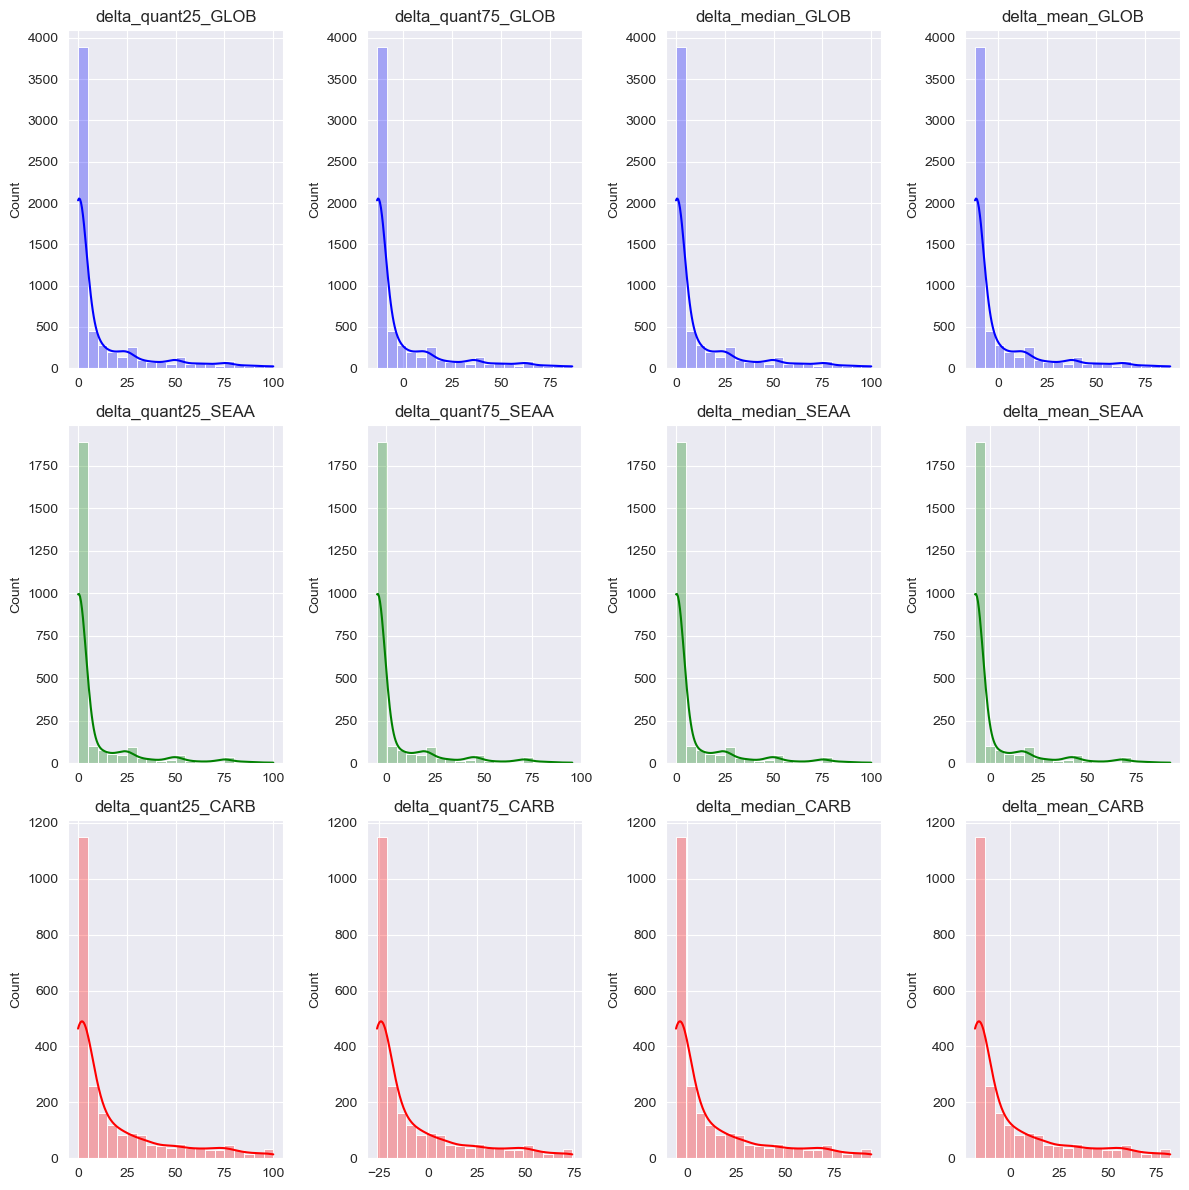

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

deltas = {'delta_quant25_GLOB': delta_quant25_GLOB, 'delta_quant75_GLOB': delta_quant75_GLOB, 'delta_median_GLOB': delta_median_GLOB,'delta_mean_GLOB': delta_mean_GLOB,
          'delta_quant25_SEAA': delta_quant25_SEAA, 'delta_quant75_SEAA': delta_quant75_SEAA, 'delta_median_SEAA': delta_median_SEAA,'delta_mean_SEAA': delta_mean_SEAA,
          'delta_quant25_CARB': delta_quant25_CARB, 'delta_quant75_CARB': delta_quant75_CARB, 'delta_median_CARB': delta_median_CARB,'delta_mean_CARB': delta_mean_CARB}

colors = ['blue', 'green', 'red']
alpha = 0.3

counter = 0
for i in range(3):
    for j in range(4):

        df_name = list(deltas.keys())[counter]
        df = deltas[df_name].values.ravel()
        ax = sns.histplot(x=df, ax=axes[i, j], color=colors[i], alpha=alpha, bins=20, kde=True)
        axes[i, j].set_title(df_name)

        counter += 1

plt.tight_layout()
plt.show()